In [ ]:
%%capture
!wget "https://drive.google.com/uc?export=download&id=1AYKP7N8d-RR_hY5jEM3qxF1n0CGsnUkd&confirm=yes" -O "kaggle.json"
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download bulentsiyah/semantic-drone-dataset
!unzip semantic-drone-dataset.zip -d data

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.patches as mpatches

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 97 kB 7.4 MB/s 
     |████████████████████████████████| 58 kB 7.3 MB/s 
     |████████████████████████████████| 376 kB 61.9 MB/s 


In [ ]:
IMAGE_PATH = 'data/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = 'data/dataset/semantic_drone_dataset/label_images_semantic/'

In [ ]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [ ]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.08, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.05, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  349
Val Size     :  19
Test Size    :  32


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


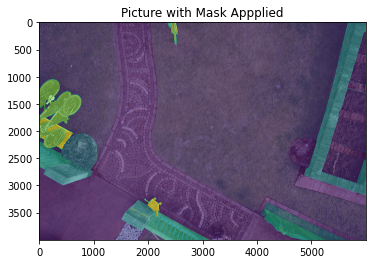

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][99] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][99] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [ ]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val)

# Model

In [ ]:
# model = smp.Unet(
#     'mobilenet_v2',
#     encoder_weights='imagenet',
#     classes=23,
#     activation=None,
#     encoder_depth=5,
#     decoder_channels=[256, 128, 64, 32, 16]
# )

model = smp.DeepLabV3Plus(
    'efficientnet-b1',
    encoder_weights='imagenet',
    classes=23,
    activation=None,
    encoder_depth=5,
    decoder_channels=256
)

# Training

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        #training loop
        model.train()
        
        for i, data in enumerate(tqdm(train_loader)):
            
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            #forward
            output = model(image)
            loss = criterion(output, mask)

            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0
        #validation loop
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                #reshape to 9 patches from single image, delete batch size
                image_tiles, mask_tiles = data
                
                image = image_tiles.to(device); mask = mask_tiles.to(device);
                output = model(image)
                #evaluation metrics
                val_iou_score +=  mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)
                #loss
                loss = criterion(output, mask)                                  
                test_loss += loss.item()
        
        #calculatio mean for each batch
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))


        if min_loss > (test_loss/len(val_loader)):
            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
            min_loss = (test_loss/len(val_loader))          

        if (test_loss/len(val_loader)) > min_loss:
            min_loss = (test_loss/len(val_loader))
            print('Loss Not Decrease')
        
        #iou
        val_iou.append(val_iou_score/len(val_loader))
        train_iou.append(iou_score/len(train_loader))
        train_acc.append(accuracy/len(train_loader))
        val_acc.append(test_accuracy/ len(val_loader))
        print("Epoch:{}/{}..".format(e+1, epochs),
                "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [32]:
#dataloader
batch_size = 4

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True
)

#training
max_lr = 1e-3
epoch = 25
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)
torch.save(model, 'Unet-Mobilenet.pt')

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.579 
Epoch:1/25.. Train Loss: 2.609.. Val Loss: 1.579.. Train mIoU:0.066.. Val mIoU: 0.128.. Train Acc:0.369.. Val Acc:0.664.. Time: 4.93m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 1.579 >> 1.010 
Epoch:2/25.. Train Loss: 1.546.. Val Loss: 1.010.. Train mIoU:0.120.. Val mIoU: 0.169.. Train Acc:0.632.. Val Acc:0.730.. Time: 4.88m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 1.010 >> 0.748 
Epoch:3/25.. Train Loss: 1.104.. Val Loss: 0.748.. Train mIoU:0.174.. Val mIoU: 0.238.. Train Acc:0.699.. Val Acc:0.785.. Time: 4.93m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.748 >> 0.613 
Epoch:4/25.. Train Loss: 0.863.. Val Loss: 0.613.. Train mIoU:0.262.. Val mIoU: 0.320.. Train Acc:0.754.. Val Acc:0.819.. Time: 4.90m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:5/25.. Train Loss: 0.757.. Val Loss: 0.729.. Train mIoU:0.305.. Val mIoU: 0.311.. Train Acc:0.773.. Val Acc:0.788.. Time: 4.92m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.729 >> 0.536 
Epoch:6/25.. Train Loss: 0.672.. Val Loss: 0.536.. Train mIoU:0.362.. Val mIoU: 0.405.. Train Acc:0.797.. Val Acc:0.832.. Time: 4.90m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:7/25.. Train Loss: 0.646.. Val Loss: 0.571.. Train mIoU:0.382.. Val mIoU: 0.382.. Train Acc:0.802.. Val Acc:0.831.. Time: 4.95m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.571 >> 0.467 
Epoch:8/25.. Train Loss: 0.543.. Val Loss: 0.467.. Train mIoU:0.418.. Val mIoU: 0.431.. Train Acc:0.834.. Val Acc:0.855.. Time: 4.93m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:9/25.. Train Loss: 0.567.. Val Loss: 0.480.. Train mIoU:0.422.. Val mIoU: 0.455.. Train Acc:0.823.. Val Acc:0.848.. Time: 4.92m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.480 >> 0.462 
Epoch:10/25.. Train Loss: 0.455.. Val Loss: 0.462.. Train mIoU:0.460.. Val mIoU: 0.485.. Train Acc:0.857.. Val Acc:0.854.. Time: 4.92m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.462 >> 0.422 
Epoch:11/25.. Train Loss: 0.419.. Val Loss: 0.422.. Train mIoU:0.485.. Val mIoU: 0.454.. Train Acc:0.868.. Val Acc:0.862.. Time: 4.91m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.422 >> 0.372 
Epoch:12/25.. Train Loss: 0.393.. Val Loss: 0.372.. Train mIoU:0.507.. Val mIoU: 0.490.. Train Acc:0.877.. Val Acc:0.874.. Time: 4.88m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.372 >> 0.364 
Epoch:13/25.. Train Loss: 0.362.. Val Loss: 0.364.. Train mIoU:0.519.. Val mIoU: 0.477.. Train Acc:0.885.. Val Acc:0.883.. Time: 4.88m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.364 >> 0.358 
Epoch:14/25.. Train Loss: 0.371.. Val Loss: 0.358.. Train mIoU:0.517.. Val mIoU: 0.482.. Train Acc:0.882.. Val Acc:0.884.. Time: 4.86m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.358 >> 0.354 
Epoch:15/25.. Train Loss: 0.330.. Val Loss: 0.354.. Train mIoU:0.542.. Val mIoU: 0.501.. Train Acc:0.893.. Val Acc:0.886.. Time: 4.85m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.354 >> 0.345 
Epoch:16/25.. Train Loss: 0.364.. Val Loss: 0.345.. Train mIoU:0.531.. Val mIoU: 0.506.. Train Acc:0.882.. Val Acc:0.889.. Time: 4.81m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.345 >> 0.317 
Epoch:17/25.. Train Loss: 0.315.. Val Loss: 0.317.. Train mIoU:0.548.. Val mIoU: 0.546.. Train Acc:0.898.. Val Acc:0.895.. Time: 4.81m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.317 >> 0.281 
Epoch:18/25.. Train Loss: 0.290.. Val Loss: 0.281.. Train mIoU:0.565.. Val mIoU: 0.529.. Train Acc:0.905.. Val Acc:0.909.. Time: 4.78m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:19/25.. Train Loss: 0.282.. Val Loss: 0.293.. Train mIoU:0.572.. Val mIoU: 0.551.. Train Acc:0.908.. Val Acc:0.904.. Time: 4.81m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:20/25.. Train Loss: 0.272.. Val Loss: 0.295.. Train mIoU:0.576.. Val mIoU: 0.522.. Train Acc:0.911.. Val Acc:0.903.. Time: 4.81m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.295 >> 0.291 
Epoch:21/25.. Train Loss: 0.256.. Val Loss: 0.291.. Train mIoU:0.588.. Val mIoU: 0.592.. Train Acc:0.915.. Val Acc:0.905.. Time: 4.82m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Not Decrease
Epoch:22/25.. Train Loss: 0.250.. Val Loss: 0.299.. Train mIoU:0.586.. Val mIoU: 0.548.. Train Acc:0.917.. Val Acc:0.902.. Time: 4.77m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.299 >> 0.297 
Epoch:23/25.. Train Loss: 0.250.. Val Loss: 0.297.. Train mIoU:0.592.. Val mIoU: 0.549.. Train Acc:0.917.. Val Acc:0.903.. Time: 4.79m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.297 >> 0.291 
Epoch:24/25.. Train Loss: 0.248.. Val Loss: 0.291.. Train mIoU:0.591.. Val mIoU: 0.544.. Train Acc:0.918.. Val Acc:0.904.. Time: 4.82m


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Loss Decreasing.. 0.291 >> 0.286 
Epoch:25/25.. Train Loss: 0.249.. Val Loss: 0.286.. Train mIoU:0.591.. Val mIoU: 0.559.. Train Acc:0.918.. Val Acc:0.906.. Time: 4.78m
Total time: 121.55 m


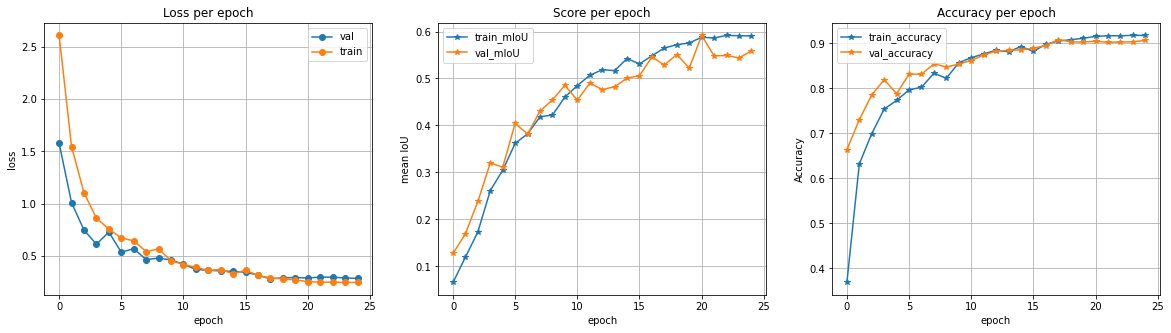

In [33]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()

plt.figure(figsize=(20,5))
plt.subplot(1,3,1); plot_loss(history)
plt.subplot(1,3,2); plot_score(history)
plt.subplot(1,3,3); plot_acc(history)
plt.show()

# Evaluation

In [34]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [35]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [36]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

mob_miou = miou_score(model, test_set)
print('Test Set mIoU', np.mean(mob_miou))

  0%|          | 0/32 [00:00<?, ?it/s]

Test Set mIoU 0.588314214271361


In [37]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

mob_acc = pixel_acc(model, test_set)
print('Test Set Pixel Accuracy', np.mean(mob_acc))

  0%|          | 0/32 [00:00<?, ?it/s]

Test Set Pixel Accuracy 0.9167123723913122


In [38]:
def plot_seg_mask(mask, ax, title, labels):
    im = ax.imshow(mask)
    ax.set_title(title)
    ax.set_axis_off()

    label = labels.loc[mask.unique().tolist()].name.to_list()
    values = np.unique(mask.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label=lab) for i,lab in enumerate(label) ]

    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def display_results(i, test_set, model):
    image1, mask1 = test_set[i]
    pred_mask1, score1 = predict_image_mask_miou(model, image1, mask1)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
    ax1.imshow(image1)
    ax1.set_title('Picture')

    plot_seg_mask(mask1, ax2, "Ground truth", label)
    plot_seg_mask(pred_mask1, ax3, 'UNet-MobileNet | mIoU {:.3f}'.format(score1), label)

    fig.tight_layout()

In [39]:
label = pd.read_csv("data/class_dict_seg.csv")

display_results(1, test_set, model)
display_results(2, test_set, model)
display_results(4, test_set, model)
display_results(6, test_set, model)
display_results(8, test_set, model)
display_results(12, test_set, model)

Output hidden; open in https://colab.research.google.com to view.